In [1]:
# Importing libraries
import numpy as np
import math
import torch
import pyro
import pyro.distributions as dist
from pyro.distributions.torch_distribution import TorchDistribution
from pyro.contrib.oed.eig import marginal_eig, nmc_eig,\
    laplace_eig, lfire_eig, donsker_varadhan_eig, _safe_mean_terms
from pyro.optim import Adam
from pyro.contrib.util import rmv, rvv, lexpand, rexpand
from torch.distributions.constraints import positive, positive_definite, lower_cholesky
from pyro import poutine
#from pyro.infer import Trace_ELBO
#from pyro.contrib.oed.glmm.guides import LinearModelLaplaceGuide

import matplotlib
import matplotlib.pyplot as plt
#plt.style.use('dark_background')
import time

from scipy.integrate import solve_ivp
from scipy.stats import gamma, lognorm, norm, gaussian_kde
import scipy.stats as stats
from scipy.optimize import differential_evolution, LinearConstraint, Bounds

import seaborn as sns
import pandas as pd

# Deterministic ODE model
This part defines and solves the ODE-system of the 3-compartment
model.

In [2]:
# Constants from Table 1 in Cascone et al. 2013
# volumes
V1t, V2t, V3t = 7.88, 23.9, 13.8

# clearance rates
c1t, c2t, c3t = 2.08, 0.828, 0.0784

# transport coefficients
k10t, k12t, k21t, k13t, k31t = 0.172, 0.373, 0.103, 0.0367, 0.0124

In [3]:
# Numerical solution to the ODE system
# 'LSODA' was found to be the fastest algorithm
def H(t, V1, V2, V3, c1, c2, c3,
      k10, k12, k21, k13, k31):
    
    def rhs(t, C, V1, V2, V3, c1, c2, c3,
            k10, k12, k21, k13, k31):
        """right hand side of ODE system"""

        # intraveneous injection
        def I(t):
            """
            intraveneous injection with rate 1 mug /(kg*min)
            for the first 20 minutes
            """
            return 1 if t <= 20 else 0
        
        dC1dt = (-(c1+(k12+k13+k10)*V1)*C[0] + k21*V2*C[1]\
                 + k31*V3*C[2] + I(t)) / V1
        dC2dt = (k12*V1*C[0] - (k21*V2+c2)*C[1]) / V2
        dC3dt = (k13*V1*C[0] - (k31*V3+c3)*C[2]) / V3
        return np.array([dC1dt, dC2dt, dC3dt])

    # start value
    C0 = np.array([0, 0, 0])
    # Jacobian
    J = np.array([[-c1/V1-k12-k13-k10, k21*V2/V1, k31*V3/V1],
                  [k12*V1/V2, -k21-c2/V2, 0],
                  [k13*V1/V3, 0, -k31-c3/V3]])
    jac = lambda t, C: J
    fun = lambda t, C: rhs(t, C, V1, V2, V3, c1, c2, c3,
                           k10, k12, k21, k13, k31)
    # solving initial value problem
    res = solve_ivp(fun, y0 = C0, t_span = (0, torch.max(t).numpy()),
                    t_eval = t, method = 'LSODA', jac = jac,
                    rtol = 1e-2, atol = 1e-5)
    return res['y']

We investigate how the concentrations evolve over time for the given
parameter values. This gives us an idea at which time points
measurements are actually feasible, i.e. the concentration is not too
low to be measured.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


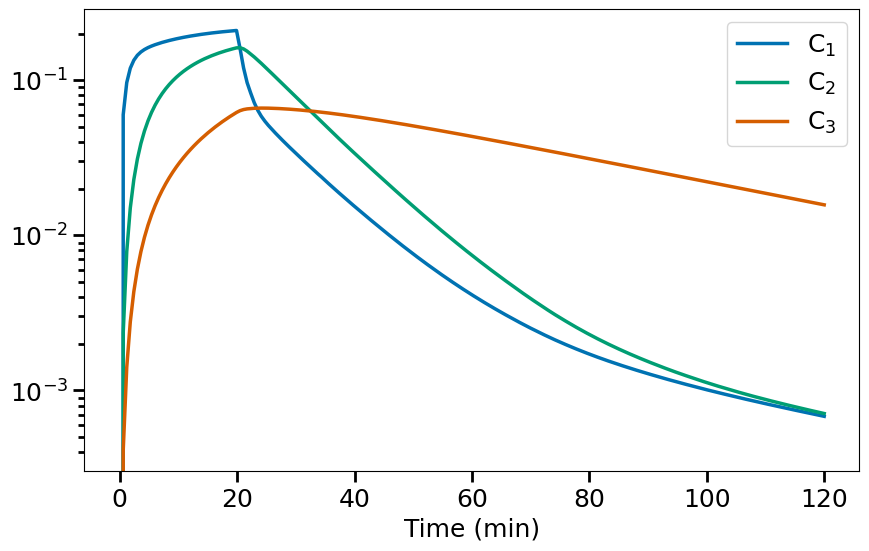

In [4]:
t = np.linspace(0, 120, 200)
C = H(torch.tensor(t), V1t, V2t, V3t, c1t, c2t, c3t,
      k10t, k12t, k21t, k13t, k31t)
# plt.style.use('default')
with plt.style.context('seaborn-colorblind'):
    matplotlib.rcParams['ytick.minor.size'] = 4
    matplotlib.rcParams['ytick.minor.width'] = 2
    plt.rc('font', size=15) 
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.plot(t, C[0,:], lw = 2.5, label = "$\mathrm{C}_{1}$")
    ax.plot(t, C[1,:], lw = 2.5, label = "$\mathrm{C}_{2}$")
    ax.plot(t, C[2,:], lw = 2.5, label = "$\mathrm{C}_{3}$")
    ax.tick_params(width = 2, length = 8, labelsize = 'large')
    plt.yscale('log')
    ax.legend(fontsize = 'large')
    ax.set_xlabel("Time (min)", fontsize = 'large')
    fig.savefig("ode-plot.eps")
    fig.savefig("ode-plot.pdf")

We see that at 60-80 minutes some concentrations become very
low and hence hard to measure. For this reason, we only consider
designs with measurements within the first 70 minutes.

# Estimation of EIG (Expected Information Gain)
This part estimates the expected information gain for one specified
design, i.e. points of time when a measurement is taken. At the
moment, we're only able to estimated the EIG for all
parameters. Singling out a subset of interesting parameters is hard
because, thus, the likelihoods that are needed become implicit.

## Model for Bayesian statistics
The distribution and the variance of the prior distributions is based
on common choices and represents our believes about the respective
parameters.

We define two models: one where the shape of the concentrations is
`(num_meas, 3)`; one with shape `(num_meas*3,)`

In [7]:
def model_maker(flat = False, only_prior = False):
    
    def model_3comp(t):
        """
        :param t: (torch.tensor) shape: (batch_dim, num_meas)
        """    
        with pyro.plate_stack("plate_stack_3comp", t.shape[:-1]):
            # prior distributions on parameters
            V1 = pyro.sample("V1", dist.Normal(torch.tensor(V1t),
                                               0.2 * torch.tensor(V1t)))
            V2 = pyro.sample("V2", dist.Normal(torch.tensor(V2t),
                                               0.2 * torch.tensor(V2t)))
            V3 = pyro.sample("V3", dist.Normal(torch.tensor(V3t),
                                               0.2 * torch.tensor(V3t)))
            c1 = pyro.sample("c1", dist.LogNormal(torch.tensor(c1t),
                                                  0.4 * torch.tensor(c1t)))
            c2 = pyro.sample("c2", dist.LogNormal(torch.tensor(c2t),
                                                  0.4 * torch.tensor(c2t)))
            c3 = pyro.sample("c3", dist.LogNormal(torch.tensor(c2t),
                                                  0.4 * torch.tensor(c2t)))
            k10 = pyro.sample("k10", dist.Normal(torch.tensor(k10t),
                                                 0.2 * torch.tensor(k10t)))
            k12 = pyro.sample("k12", dist.Normal(torch.tensor(k12t),
                                                 0.2 * torch.tensor(k12t)))
            k21 = pyro.sample("k21", dist.Normal(torch.tensor(k21t),
                                                 0.2 * torch.tensor(k21t))) 
            k13 = pyro.sample("k13", dist.Normal(torch.tensor(k13t),
                                                 0.2 * torch.tensor(k13t)))
            k31 = pyro.sample("k31", dist.Normal(torch.tensor(k31t),
                                                 0.2 * torch.tensor(k31t)))
            sigma = pyro.sample("sigma", dist.Gamma(2, 31)) # actually sigma^2

            if only_prior:
                return V1, V2, V3, c1, c2, c3, k10, k12, k21, k13, k31, sigma
            
            # Solving ODE system for each batch separately
            l = len(t.shape)
            mu = np.zeros(t.shape + (3,))
            if l == 2:
                for i in range(t.shape[0]):
                    mu[i,:,:] = np.transpose( H(t[i,:], V1[i], V2[i], V3[i],
                                                c1[i], c2[i], c3[i],
                                                k10[i], k12[i], k21[i], k13[i], k31[i]) )
            elif l == 3:
                for i in range(t.shape[0]):
                    for j in range(t.shape[1]):
                        mu[i,j,:,:] = np.transpose(H(t[i,j,:],
                                                     V1[i,j], V2[i,j], V3[i,j],
                                                     c1[i,j], c2[i,j], c3[i,j],
                                                     k10[i,j], k12[i,j], k21[i,j],
                                                     k13[i,j], k31[i,j]))
            else:
                assert 0 == 1, "Build better code!"

            if flat:
                # flattening mu
                mu = mu.reshape(mu.shape[:-2] + (mu.shape[-2] * mu.shape[-1],))

            # protection against numerical instabilities
            mu = torch.maximum(torch.tensor(mu), torch.tensor(1e-12))

            if flat:
                sigma_ex = rexpand(sigma, mu.shape[-1])
                C = pyro.sample("C", dist.Normal(torch.log(mu), torch.sqrt(sigma_ex)).to_event(1))
            else:
                sigma_ex = rexpand(sigma, mu.shape[-2], mu.shape[-1])
                C = pyro.sample("C", dist.Normal(torch.log(mu), torch.sqrt(sigma_ex)).to_event(2))
            return C

    return model_3comp

Notes on the prior of `sigma`:
* The Gamma distribution is popular due to its support on [0, infty)
  and the fact that it's conjugate to the normal distribution.
* The first parameter decides how "sharp" the distribution is around
  its mean.
* Choice of the mean: Due to the log-transformation, we assume that
  the concentrations on the original scale follow a lognormal
  distribution. On this scale, we suppose that the standard-deviation
  is ~25 % of the mean. If we use the formula for the covariance,
  we find that `sigma**2 = 0.06`, hence `sigma = 0.24`. (This is not
  entirely rigorous.)
  
## Nested Monte Carlo (NMC)
This method is easy and consistent but we found that it doesn't converge in
reasonable time.

In [6]:
# test design
test_t = torch.tensor([1, 10, 25, 40, 60])
# model creation
model_3comp = model_maker(flat = False)

In [8]:
pyro.clear_param_store()
tic = time.time()
est_nmc = nmc_eig(model_3comp, test_t, "C", None, N = 400, M = 20)
toc = time.time()
print('NMC estimate: ', est_nmc.numpy())
print('Time: ', toc-tic)

NMC estimate:  58.60412648303614
Time:  9.475545883178711


Note: `N` should be chosen of order `O(M^2)`

## Variational Marginal Preliminaries
We found that 'Variational Marginal' is among the few methods
presented in Foster et al. (2020) which are suitable for our problem
as we can simulate data to get an idea of the distribution
`p(C|t)`. In this section, we undertake some preliminary experiments
to get good approximations.

In [9]:
# Sampling concentrations from 5000 experiments
T = test_t.repeat(5000, 1)
C_samples = model_3comp(T)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


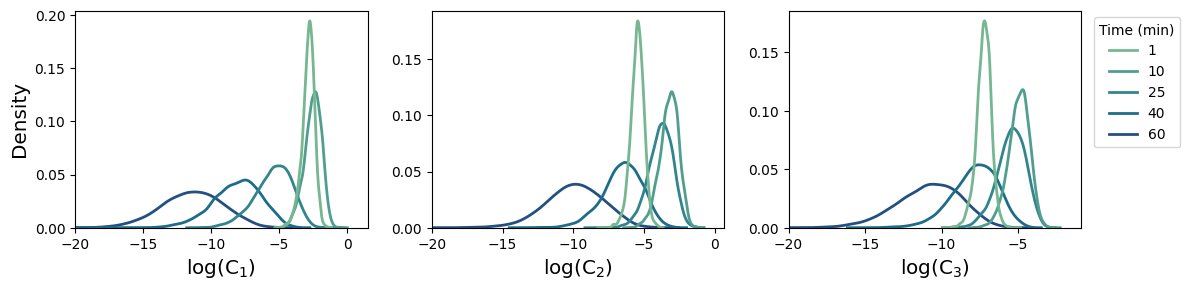

In [10]:
# Non-parametric estimation of the marginal pdf's p(C|t)
# via kernel density estimation (KDE)
fig, ax = plt.subplots(figsize = (12, 3), nrows=1, ncols  = 3)
for i in range(3):
    data = C_samples[:,:,i].numpy()
    pd_data = pd.DataFrame(data, columns = test_t.numpy())
    sns_plot = sns.kdeplot(ax = ax[i], data = pd_data,
                           palette = 'crest', legend = i==2,
                           **{'lw': 2})
    ax[i].set_xlim(left = -20)
    if i > 0:
        ax[i].set_ylabel("")
    else:
        ax[i].set_ylabel("Density", fontsize = 'x-large')
    s = "$\log(\mathrm{C}_{" + str(i+1) + "})$"
    ax[i].set_xlabel(s, fontsize = 'x-large')
    if i == 2:
        leg = ax[i].get_legend()
        leg.set_title('Time (min)')
        leg.fontsize = 'x-large'
        leg.set_bbox_to_anchor((1.02, 1))
    
plt.tight_layout()
fig.savefig("marg-density.pdf")
fig.savefig("marg-density.eps")

We notice that the marginal pdf's look close to normal. We further
investigate this with PP-plots (similar to QQ-plot).

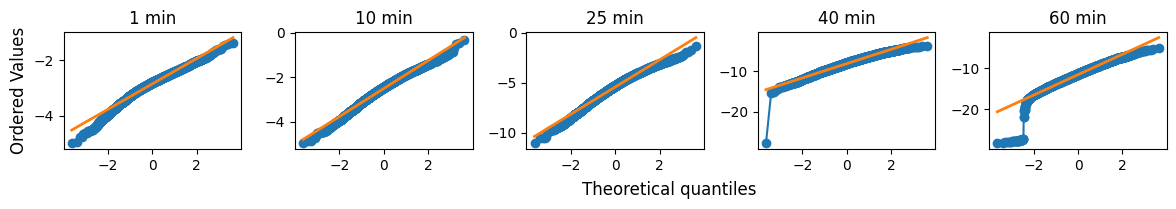

In [11]:
Cnum = 0
fig, ax = plt.subplots(figsize = (12, 2.5), nrows = 1, ncols = 5)
for i in range(5):
    (osm, osr), (slope, intercept, r) = stats.probplot(C_samples[:,i,Cnum].numpy(),
                                                       plot = None,
                                                       fit = True,
                                                       dist = stats.norm)
    with plt.style.context('seaborn-colorblind'):
        ll, bb, ww, hh = ax[i].get_position().bounds
        ax[i].set_position([ll, 0, ww, 1])
        ax[i].plot(osm, osr, marker = 'o')
        ax[i].plot(osm, slope*osm + intercept, lw = 2)
        if i == 0:
            ax[i].set_ylabel("Ordered Values", fontsize = 'large')
        ax[i].set_title(str(test_t[i].numpy()) + " min", fontsize = 'large')

plt.tight_layout()
fig.text(0.5, 0.1, "Theoretical quantiles", va='center', fontsize = 'large')
fig.savefig("pp-plot.pdf")
fig.savefig("pp-plot.eps")

We find that the assumption of a Gaussian distribution is reasonable.
An exponential power distribution with parameter `1.7` is an even
better fit. However, this distribution is not implemented in PyTorch.

Lastly, we analyse the covariance structure of the 3*5 concentrations.

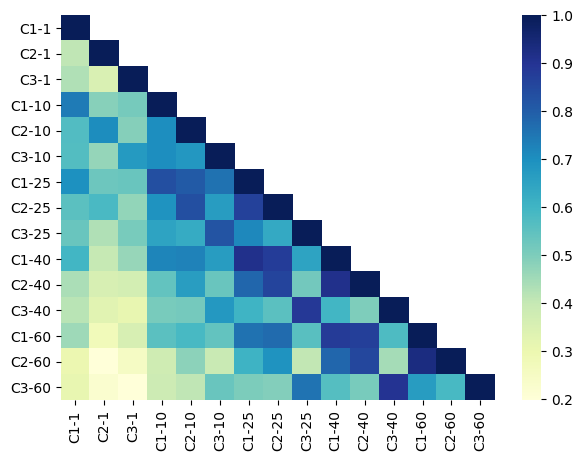

In [13]:
col_names = []
for t in test_t.numpy():
    for i in range(3):
        col_names.append("C" + str(i+1) + "-" + str(t))

# Investigation of correlation matrix
data = C_samples.reshape((-1, 3*5)).numpy() # 5000, 5, 3

corr = np.corrcoef(np.transpose(data))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask, k = 1)] = True
corr_pd = pd.DataFrame(corr,
                       columns = col_names,
                       index = col_names)

fig, ax = plt.subplots(figsize = (7,5))
ax = sns.heatmap(corr_pd, cmap="YlGnBu", mask = mask)

fig.savefig("corr.pdf")
fig.savefig("corr.eps")

We see that many variables are highly correlated. Moreover, the 3rd,
6th and 9th off-diagonal show a somewhat strong correlation pattern. This is
sensible as the measurement of one concentration is highly correlated
with the measurements of the same concentration at neighbouring points
in time.

In the two following sections we implement approximations of
the marginal pdf p(C|t) via a Gaussian distribution or KDE. For each
method, we consider three kinds of approximation:
* factorised: p(C|t) is modelled as a product of densities of the 3*7
  measured concentrations
* non-factorised: p(C|t) is modelled as one density and doesn't have a
  product structure
* partially factorised: p(C|t) is modelled as product of densities of
  the 3 different concentrations

The first approach doesn't account for correlation; the second
accounts for every kind of correlation; the third one only accounts
for correlation along time.

## Variational Marginal - Normal approximation

In [14]:
# Factorised approximation
def guide_fact(t, observation_labels, target_labels):
    """
    Abuse of `target_labels` as a channel to give
    information to the guide.
    """
    mean, std = target_labels
    C = pyro.sample("C", dist.Normal(mean, std).to_event(2))
    return C

In [15]:
pyro.clear_param_store()
tic = time.time()
num_rep = 800
T = test_t.repeat(num_rep, 1)
sample = model_3comp(T) # shape: (num_rep, t.shape[-1], 3)
std, mean  = torch.std_mean(sample, dim = 0)

est_norm_fact = marginal_eig(model_3comp, test_t, "C", (mean, std),
                             num_steps = 0, guide = guide_fact,
                             num_samples = 800, optim = Adam({"lr": 0.001}))
# the optimiser is actually not used
toc = time.time()
print('Time: ', toc-tic)
print('EIG: ', est_norm_fact.numpy())

Time:  38.15958213806152
EIG:  23.514082285714206


In [16]:
# Non-factorised approximation
def guide_nonfact(t, observation_labels, target_labels):
    mean, cov  = target_labels
    C = pyro.sample("C", dist.MultivariateNormal(mean, cov))
    return C

In [17]:
# The non-factorised approximation requires the flat model
model_3comp_flat = model_maker(flat = True)

In [18]:
pyro.clear_param_store()
tic = time.time()
num_rep = 800
T = test_t.repeat(num_rep, 1)
sample = model_3comp_flat(T) # shape: (num_rep, t.shape[-1]* 3)
mean = torch.mean(sample, dim = 0)
cov = np.cov(np.transpose(sample.numpy()))
cov = torch.tensor(cov)
est_norm_nonfact = marginal_eig(model_3comp_flat, test_t, "C", (mean, cov),
                                num_steps = 0, guide = guide_nonfact,
                                num_samples = 800, optim = Adam({"lr": 0.001}))
toc = time.time()
print('Time: ', toc-tic)
print('EIG: ', est_norm_nonfact.numpy())

Time:  39.589930295944214
EIG:  12.463665197420557


In [19]:
# Partially factorised approximation
pyro.clear_param_store()
tic = time.time()

num_rep = 800 # to be tuned
T = test_t.repeat(num_rep, 1)
sample = model_3comp_flat(T)
mean = torch.mean(sample, dim = 0)

cov = np.cov(np.transpose(sample.numpy()))
cov_half = np.zeros(cov.shape)
# only keeping the time-dependence
for i in range(cov.shape[0]):
    for j in range(cov.shape[1]):
        cov[i][j] = cov[i][j] if np.abs(i-j) % 3 == 0 else 0
cov = torch.tensor(cov)

est_norm_parfact = marginal_eig(model_3comp_flat, test_t, "C", (mean, cov),
                                num_steps = 0, guide = guide_nonfact,
                                num_samples = 800, optim = Adam({"lr": 0.001}))
toc = time.time()
print('Time: ', toc-tic)
print('EIG: ', est_norm_parfact.numpy())

Time:  39.74288082122803
EIG:  14.815868809450098


## Variational Marginal - KDE approximation
Kernel density estimation can be understood as a smoothed histogram
and allows to estimate pdf's in a non-parametric way. We first sample
from the distribution `p(C|t)`, then define a new probability
distribution based on this sample and finally apply Variational
marginal to get an estimate for EIG.

In [22]:
# Factorised approximation

# Defining a new class of probability distributions
# which corresponds to the KDE of a given sample
class KDE_Fact(TorchDistribution):
    
    def __init__(self, sample):
        self.kernel = []
        for t in range(sample.shape[1]):
            kernel_t = []
            for j in range(sample.shape[2]):
                k = gaussian_kde(sample[...,t,j].numpy())
            kernel_t.append(k)
        self.kernel.append(kernel_t)
        self.dim_t = len(self.kernel)
        self.dim_C = len(self.kernel[0])
        
        batch_shape, event_shape = (0,), sample.shape[1:]
        super(KDE_Fact, self).__init__(batch_shape, event_shape)
    
    def sample(self, sample_shape):
        s = torch.zeros(sample_shape + (self.dim_t, self.dim_C))
        for t in range(dim_t):
            for j in range(dim_C):
                draw = self.kernel[t][j].resample(sample_shape)
                s[...,t,j] = torch.tensor(draw)
        return s
    
    def log_prob(self, x):
        p = torch.zeros(x.shape[:-2])
        for t in range(self.dim_t):
            for j in range(self.dim_C):
                p += torch.tensor(self.kernel[t][j].logpdf(x[...,t,j].numpy()))
        return p

def guide_kde_fact(t, observation_labels, target_labels):
    sample = target_labels
    C = pyro.sample("C", KDE_Fact(sample))
    return C

In [23]:
pyro.clear_param_store()
tic = time.time()
num_rep = 800
T = test_t.repeat(num_rep, 1)
sample = model_3comp(T) # shape: (num_rep, t.shape[-1], 3)

est_kde_fact = marginal_eig(model_3comp, test_t, "C", sample,
                            num_steps = 0, guide = guide_kde_fact,
                            num_samples = 800, optim = Adam({"lr": 0.001}))
toc = time.time()
print('Time: ', toc-tic)
print('EIG: ', est_kde_fact.numpy())

Time:  38.703784227371216
EIG:  19.697294


In [24]:
# Non-factorised approximation
class KDE_NonFact(TorchDistribution):

    def __init__(self, sample):
        values = np.moveaxis(sample.numpy(), 0, -1)
        self.kernel = gaussian_kde(values)
        batch_shape, event_shape = (0,), sample.shape[1:]
        super(KDE_NonFact, self).__init__(batch_shape, event_shape)

    def sample(self, sample_shape):
        s = self.kernel.resample(sample_shape)
        return torch.tensor(np.moveaxis(s, 0, -1))
    
    def log_prob(self, x):
        x = np.moveaxis(x.numpy(), -1, 0)
        return torch.tensor(self.kernel.logpdf(x))

def guide_kde_nonfact(t, observation_labels, target_labels):
    sample = target_labels
    C = pyro.sample("C", KDE_NonFact(sample))
    return C

In [25]:
pyro.clear_param_store()
tic = time.time()
num_rep = 800 
T = test_t.repeat(num_rep, 1)
sample = model_3comp_flat(T) # shape: (num_rep, t.shape[-1]*3)

est_kde_nonfact = marginal_eig(model_3comp_flat, test_t, "C", sample,
                            num_steps = 0, guide = guide_kde_nonfact,
                            num_samples = 800, optim = Adam({"lr": 0.001}))
toc = time.time()
print('Time: ', toc-tic)
print('EIG: ', est_kde_nonfact.numpy())

Time:  41.197630167007446
EIG:  12.218190799303908


In [26]:
# Partially factorised approximation
class KDE_ParFact(TorchDistribution):

    def __init__(self, sample):
        self.dim_C = sample.shape[-1]
        self.dim_t = sample.shape[-2]
        self.kernel = []
        for j in range(sample.shape[2]):
            k = gaussian_kde(np.moveaxis(sample[:,:,j].numpy(), 0, -1))
            self.kernel.append(k)
        batch_shape, event_shape = (0,), sample.shape[1:]
        super(KDE_ParFact, self).__init__(batch_shape, event_shape)
    
    def sample(self, sample_shape):
        s = torch.zeros(sample_shape + (self.dim_t, self.dim_C))
        for j in range(self.dim_C):
            draw = self.kernel[j].resample(sample_shape)
            s[...,j] = torch.tensor(draw)
        return s
    
    def log_prob(self, x):
        p = torch.zeros(x.shape[:-2])
        for j in range(self.dim_C):
            x_np = np.moveaxis(x[...,j].numpy(), 0, -1)
            p += torch.tensor(self.kernel[j].logpdf(x_np))
        return p

def guide_kde_parfact(t, observation_labels, target_labels):
    sample = target_labels
    C = pyro.sample("C", KDE_ParFact(sample))
    return C

In [27]:
pyro.clear_param_store()
tic = time.time()
num_rep = 800
T = test_t.repeat(num_rep, 1)
sample = model_3comp(T) # shape: (num_rep, t.shape[-1], 3)

est_kde_parfact = marginal_eig(model_3comp, test_t, "C", sample,
                               num_steps = 0, guide = guide_kde_parfact,
                               num_samples = 800, optim = Adam({"lr": 0.001}))
toc = time.time()
print('Time: ', toc-tic)
print('EIG: ', est_kde_parfact.numpy())

Time:  36.942991733551025
EIG:  14.337698


## Investigation: Stability vs. Run-time
Meaningful optimisation can only be achieved when the estimated EIG
value is stable. Otherwise the optimisation algorithm will sooner or
later find a configuration which produces a good EIG value just by
chance, or rather instability, and assume that it is close to optimal
when it actually isn't.
Therefore, we investigate the stability of NMC- and variational
marginal estimates allowing for computation times for one estimate
between roughly 10 and 60 seconds.

In [131]:
num_run = 50

# NMC estimator
m_list = np.array([20, 27, 37, 45])
n_list = m_list**2

res = np.zeros((num_run, m_list.shape[0]))
times = np.zeros(m_list.shape[0])
for i, (n, m) in enumerate(zip(n_list, m_list)):
    for j in range(num_run):
        pyro.clear_param_store()
        tic = time.time()
        res[j, i] = nmc_eig(model_3comp, test_t, "C", None, N = n, M = m)
        toc = time.time()
        times[i] += toc - tic

times /= num_run

In [146]:
# Variational marginal factorised normal approximation
sample_list = np.array([200, 450, 700, 900])

res2 = np.zeros((num_run, sample_list.shape[0]))
times2 = np.zeros(sample_list.shape[0])
for i, n in enumerate(sample_list):
    for j in range(num_run):
        pyro.clear_param_store()
        tic = time.time()
        T = test_t.repeat(n, 1)
        sample = model_3comp(T) # shape: (num_rep, t.shape[-1], 3)
        std, mean  = torch.std_mean(sample, dim = 0)
        res2[j, i] = marginal_eig(model_3comp, test_t, "C", (mean, std),
                                 num_steps = 0, guide = guide_fact,
                                 num_samples = n, optim = Adam({"lr": 0.001}))
        toc = time.time()
        times2[i] += toc - tic

times2 /= num_run

In [ ]:
# Variational marginal non-factorised normal approximation
sample_list = np.array([200, 450, 700, 900])

res3 = np.zeros((num_run, sample_list.shape[0]))
times3 = np.zeros(sample_list.shape[0])
for i, n in enumerate(sample_list):
    for j in range(num_run):
        pyro.clear_param_store()
        tic = time.time()
        T = test_t.repeat(n, 1)
        sample = model_3comp_flat(T)
        mean = torch.mean(sample, dim = 0)
        cov = np.cov(np.transpose(sample.numpy()))
        cov = torch.tensor(cov)
        res3[j,i] = marginal_eig(model_3comp_flat, test_t, "C", (mean, cov),
                                num_steps = 0, guide = guide_nonfact,
                                num_samples = n, optim = Adam({"lr": 0.001}))
        toc = time.time()
        times3[i] += toc - tic

times3 /= num_run

In [152]:
# Variational marginal non-factorised KDE approximation
sample_list = np.array([200, 450, 700, 900])

res4 = np.zeros((num_run, sample_list.shape[0]))
times4 = np.zeros(sample_list.shape[0])
for i, n in enumerate(sample_list):
    for j in range(num_run):
        pyro.clear_param_store()
        tic = time.time()
        T = test_t.repeat(n, 1)
        sample = model_3comp_flat(T)
        res4[j,i] = marginal_eig(model_3comp_flat, test_t, "C", sample,
                                 num_steps = 0, guide = guide_kde_nonfact,
                                 num_samples = n, optim = Adam({"lr": 0.001}))
        toc = time.time()
        times4[i] += toc - tic

times4 /= num_run

In [ ]:
# Variational marginal non-factorised KDE approximation
sample_list = np.array([200, 450, 700, 900])

res6 = np.zeros((num_run, sample_list.shape[0]))
times6 = np.zeros(sample_list.shape[0])
for i, n in enumerate(sample_list):
    for j in range(num_run):
        pyro.clear_param_store()
        tic = time.time()
        T = test_t.repeat(n, 1)
        sample = model_3comp(T)
        res6[j,i] = marginal_eig(model_3comp, test_t, "C", sample,
                                 num_steps = 0, guide = guide_kde_fact,
                                 num_samples = n, optim = Adam({"lr": 0.001}))
        toc = time.time()
        times6[i] += toc - tic

times6 /= num_run

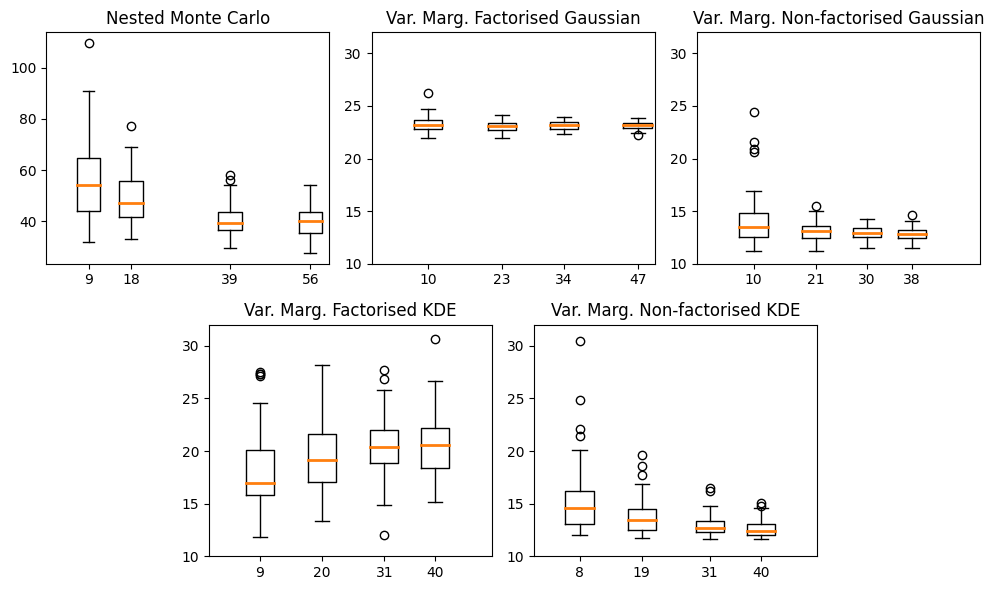

In [199]:
fig = plt.figure(figsize = (10, 6))
gs = fig.add_gridspec(2, 6)
ax1 = fig.add_subplot(gs[0, :2]) # nmc
ax2 = fig.add_subplot(gs[0, 2:4]) # normal factorised
ax3 = fig.add_subplot(gs[0, 4:]) # normal non-factorised
ax4 = fig.add_subplot(gs[1, 1:3]) # KDE factorised
ax5 = fig.add_subplot(gs[1, 3:5]) # KDE non-factorised

_ = ax1.boxplot(res, positions = times.astype(int),
                widths = 5, medianprops = {'lw':2})
_ = ax2.boxplot(res2, positions = times2.astype(int),
                widths = 5, medianprops = {'lw':2})
_ = ax3.boxplot(res3, positions = times3.astype(int),
                widths = 5, medianprops = {'lw':2})
_ = ax4.boxplot(res6, positions = times6.astype(int),
                widths = 5, medianprops = {'lw':2})
_ = ax5.boxplot(res4, positions = times4.astype(int),
                widths = 5, medianprops = {'lw':2})

axes = [ax1, ax2, ax3, ax4, ax5]
titles = ['Nested Monte Carlo', 'Var. Marg. Factorised Gaussian',
          'Var. Marg. Non-factorised Gaussian',
          'Var. Marg. Factorised KDE',
          'Var. Marg. Non-factorised KDE']
for i, (ax,t) in enumerate(zip(axes, titles)):
    if i > 0:
        ax.set_ylim([10, 32])
        ax.set_xlim([0, 50])
    else:
        ax.set_xlim([0,60])
    ax.set_title(t, fontsize = 'large')
plt.tight_layout()
fig.savefig("emp-eval.pdf")
fig.savefig("emp-eval.eps")

All of the considered estimators lead to asymptotically upper
bounds. Hence, the smallest estimates are closest to the truth. The
upper graphic illustrates that NMC is considerably worse than the
other estimators and we see that the non-factorised approximation is
superior to the factorised one. Moreover, it seems that the Gaussian
approximation yields more stable estimates than the KDE approximation
which makes the former the arguably best EIG-estimation method.

# Optimisation
Ordinary optimisation algorithms like Simulated Annealing or
Differential Evolution require a large number of function evaluations
of EIG. The upper evaluation of the stability of the estimators hints
that we cannot apply them if we have limited computational
resources. For this reason, we resort to grid search.

In the following we aim to find the best time points for 3
measurements constraining each two measurements to be at least 5
minutes apart. We search on a 5-minute grid from 0 to 60 minutes

In [209]:
designs = []
designs_np = np.zeros((286, 3))
counter = 0
for i1 in range(0, 55, 5):
    for i2 in range(i1+5, 60, 5):
        for i3 in range(i2+5, 65, 5):
            designs.append(torch.tensor([i1, i2, i3]))
            designs_np[counter,:] = np.array([i1, i2, i3])
            counter += 1

In [223]:
eig_np = np.zeros(286)
tic = time.time()
for i in range(286):
    test_t = torch.tensor(designs_np[i,:])
    T = test_t.repeat(1500, 1)
    sample = model_3comp_flat(T)
    mean = torch.mean(sample, dim = 0)
    cov = np.cov(np.transpose(sample.numpy()))
    cov = torch.tensor(cov)
    eig_np[i] = marginal_eig(model_3comp_flat, test_t, "C", (mean, cov),
                             num_steps = 0, guide = guide_nonfact,
                             num_samples = 1500, optim = Adam({"lr": 0.001}))
toc = time.time()

In [233]:
# Printing the L largest values
L = 10 # L largest values
sorted_index = np.argsort(eig_np)
for i in range(L):
    ind = sorted_index[-(i+1)]
    print("EIG: {}, design: {}".format(eig_np[ind], designs_np[ind,:]))

EIG: 13.678463845374063, design: [30. 55. 60.]
EIG: 13.019484942010799, design: [35. 55. 60.]
EIG: 12.749641928965408, design: [35. 45. 60.]
EIG: 12.038452504610156, design: [30. 50. 60.]
EIG: 11.9323325357155, design: [50. 55. 60.]
EIG: 11.925763048918688, design: [ 5. 45. 60.]
EIG: 11.867130761609694, design: [20. 50. 60.]
EIG: 11.861630364401542, design: [20. 55. 60.]
EIG: 11.847567578055148, design: [40. 55. 60.]
EIG: 11.836107643946244, design: [30. 50. 55.]


# Experimental Area
This section collects code snippets that are still under development
or weren't useful in the given framework

## Optimisation with Differential Evolution
The Scipy-implementation of Differential Evolution makes it easy to
include constraints.

In [28]:
# Function that estimates EIG based on variational marginal
# with a non-factorised Gaussian approximation
def eig(t, *args):
    num_rep = args[0]
    num_samples = args[1]
    pyro.clear_param_store()
    T = torch.tensor(t).repeat(num_rep, 1)
    sample = model_3comp_flat(T)
    mean = torch.mean(sample, dim = 0)
    cov = np.cov(np.transpose(sample.numpy()))
    cov = torch.tensor(cov)
    est_norm_nonfact = marginal_eig(model_3comp_flat, torch.tensor(t), "C", (mean, cov),
                                    num_steps = 0, guide = guide_nonfact,
                                    num_samples = num_samples, optim = Adam({"lr": 0.001}))
    return (-1) * est_norm_nonfact.numpy()

In [ ]:
# Constrained version of this function
def eig_constrained(t, *args):
    num_rep = args[0]
    num_samples = args[1]
    t_dist = args[2]

    # guaranteeing measurement distance condiction
    dist_cond = np.all((t[1:] - t[:-1]) >= t_dist)
    if dist_cond:
        pyro.clear_param_store()
        T = torch.tensor(t).repeat(num_rep, 1)
        sample = model_3comp_flat(T)
        mean = torch.mean(sample, dim = 0)
        cov = np.cov(np.transpose(sample.numpy()))
        cov = torch.tensor(cov)
        est_norm_nonfact = marginal_eig(model_3comp_flat, torch.tensor(t), "C", (mean, cov),
                                        num_steps = 0, guide = guide_nonfact,
                                        num_samples = num_samples, optim = Adam({"lr": 0.001}))
        return (-1) * est_norm_nonfact.numpy()
    else:
        return np.inf

In [ ]:
tic = time.time()
res = differential_evolution(eig, bounds, args = (200, 200),
                             strategy = 'randtobest1bin', maxiter = 5, popsize = 5,
                             mutation = 0.8, recombination = 0.8, callback = callback,
                             polish = False, disp = True, init = 'latinhypercube',
                             updating = 'immediate', workers = 1,
                             constraints = constraint)
toc = time.time()
print('Time: ', toc - tic)

differential_evolution step 1: f(x)= -26.4026
xk:  [ 0.68744942 24.91462657 52.32488681]
convergence:  0.0


differential_evolution step 2: f(x)= -30.4253
xk:  [24.60671277 43.36533216 67.18878017]
convergence:  0.0


differential_evolution step 3: f(x)= -37.7031
xk:  [28.97337851 38.21018485 59.93364917]
convergence:  0.0


differential_evolution step 4: f(x)= -49.6169
xk:  [ 5.29319609 47.59744165 61.16129413]
convergence:  0.0


differential_evolution step 5: f(x)= -49.6169
xk:  [ 5.29319609 47.59744165 61.16129413]
convergence:  0.0
Time:  441.16899704933167


## Control Variates
This approach follows an idea of Foster et al. (2020) described in
Appendix F. We use a normal approximation to the marginal distribution
as we need to find an explicit formula for the Kullback-Leibler
divergence.

In [161]:
prior_model_flat = model_maker(flat = True, only_prior = True)

In [162]:
# formula for KL distance with non-factorised marginal approx
def kl_formula_nonfact(t, model_params, mu, Sigma):
    """
    :param t: design (one-dimensional)
    :param model_params: parameters with prior; tuple of arrays
    :param mu: mean of marginal approximation
    :param Sigma: covariance matrix of marginal approximation
    """
    SigmaInv = np.linalg.pinv(Sigma)
    tr = np.trace(SigmaInv)
    logdet = np.log(np.linalg.det(Sigma))
    dim = mu.shape[0]

    V1, V2, V3, c1, c2, c3, k10, k12, k21, k13, k31, sigma = model_params

    sol = np.zeros((V1.shape[0], t.shape[0], 3))

    for i in range(V1.shape[0]):
        sol[i,:,:] = np.transpose(H(t, V1[i], V2[i], V3[i],
                                  c1[i], c2[i], c3[i],
                                  k10[i], k12[i], k21[i], k13[i], k31[i]))
    sol = sol.reshape(sol.shape[:-2] + (sol.shape[-2] * sol.shape[-1],))
    sol = np.log(np.maximum(sol, 1e-12)) # (N1, dim)

    term1 = np.mean(sigma.numpy()*tr - dim*np.log(sigma.numpy())) - dim + logdet

    # there are smarter ways than the following
    term2 = np.zeros(V1.shape[0])
    for i in range(term2.shape[0]):
        term2[i] = np.dot(np.dot(SigmaInv, sol[i,:] - mu), sol[i,:] - mu)

    return 0.5 * (term1 + np.mean(term2))

In [163]:
def control_covariate_eig(model, t, observation_labels, prior_model,
                          N1 = 100, N2 = 100, M = 10, num_rep = 100):
    """
    :param N1: repetitions KL MC
    :param N2: repetitions NMC outer
    :param M: repetitions NMC inner
    """
    # estimation of marginal approximation
    if isinstance(observation_labels, str):  # list of strings instead of strings
        observation_labels = [observation_labels]
    
    sample = model(lexpand(t, num_rep))
    mean = torch.mean(sample, dim = 0)
    cov = np.cov(np.transpose(sample.numpy()))
    cov = torch.tensor(cov)
    pyro.clear_param_store()

    # KL estimation
    # could also be solved via trace, but not as easy
    expanded_t1 = lexpand(t, N1)
    model_params = prior_model(expanded_t1)
    kl_est = kl_formula_nonfact(t, model_params, mean.numpy(), cov.numpy())

    # Nested Monte Carlo estimation
    # sampling from model
    expanded_t2 = lexpand(t, N2)
    trace = poutine.trace(model).get_trace(expanded_t2)
    y_dict = {l: trace.nodes[l]["value"] for l in observation_labels}

    # marginal guide term
    cond_guide = pyro.condition(guide_nonfact, data = y_dict)
    cond_trace = poutine.trace(cond_guide).get_trace(expanded_t2,
                                                     observation_labels,
                                                     (mean, cov))
    cond_trace.compute_log_prob()    
    nmc_guide = sum(cond_trace.nodes[l]["log_prob"] \
                    for l in observation_labels)

    # marginal model term
    y_dict_exp = {l: lexpand(trace.nodes[l]["value"], M) \
                  for l in observation_labels}
    cond_model = pyro.condition(model, data = y_dict_exp)
    reexpanded_t2 = lexpand(t, M, 1)
    retrace = poutine.trace(cond_model).get_trace(reexpanded_t2)
    retrace.compute_log_prob()
    nmc_est = sum(retrace.nodes[l]["log_prob"] \
                  for l in observation_labels).logsumexp(0) - math.log(M)

    terms = nmc_guide - nmc_est
    nonnan = (~torch.isnan(terms)).sum(0).type_as(terms)
    terms[torch.isnan(terms)] = 0.
    
    return kl_est + terms.sum(0) / nonnan

In [164]:
tic = time.time()
eig_concov = control_covariate_eig(model_3comp_flat, test_t, "C", prior_model_flat,
                                   N1 = 300, N2 = 40**2, M = 40, num_rep = 200)
toc = time.time()
print('Time: ', toc - tic)
print('EIG: ', eig_concov.numpy())

Time:  49.903422117233276
EIG:  39.55816275972077


In [ ]:
# Control covariates stability and convergence analysis
N1_list = np.array([100, 200, 250, 250])
M_list = np.array([15, 20, 30, 40])
N2_list = M_list**2
sample_list = np.array([100, 200, 250, 250])

res5 = np.zeros((num_run, sample_list.shape[0]))
times5 = np.zeros(sample_list.shape[0])
for i, (n1, n2, m, n) in enumerate(zip(N1_list, N2_list, M_list, sample_list)):
    for j in range(num_run):
        pyro.clear_param_store()
        tic = time.time()
        res5[j,i] = control_covariate_eig(model_3comp_flat, test_t, "C", prior_model_flat,
                                          N1 = n1, N2 = n2, M = m, num_rep = n)
        toc = time.time()
        times5[i] += toc - tic

times5 /= num_run

eig_concov = control_covariate_eig(model_3comp_flat, test_t, "C", prior_model_flat,
                                   N1 = 1000, N2 = 2500, M = 50, num_rep = 500)

## EIG estimation for a subset
All estimators until now computed the expected information gain for
all parameters in the model. However, we might only be interested to
pin down the values for a subset of parameters. This problem is harder
as we don't know an implicit likelihood as `p(y|c_1,d)`. NMC provides
a way of estimating it.

In [ ]:
# Estimate of EIG just for c1
est_nmc = nmc_eig(model_3comp, test_t, "C", "c1", N = 10000, M = 100,
                  M_prime = 2000, independent_priors = True)